In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sectionate
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.path as mpath

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
subplot_kws=dict(projection=ccrs.Robinson())
data_crs = ccrs.PlateCarree()

In [4]:
def plot_sections(i, j, x, y, section_lons, section_lats, grid, projection=ccrs.Robinson()):
    
    fig, axes = plt.subplots(1, 2, figsize=[16,6], subplot_kw={'projection':projection})
    ax = axes[0]
    grid['ht'].plot(x='geolon_t', y='geolat_t', ax=ax, transform=data_crs)
    ax.plot(x, y, 'k.-', transform=ccrs.Geodetic(), markersize=1.5, lw=0.5)
    ax.plot(section_lons, section_lats, "C3x", transform=data_crs, markersize=6., mew=3., alpha=0.85, label="Points of target section")
    ax.plot([80,80], [-75, 90], "w--", alpha=0.75, lw=1.75, transform=ccrs.Geodetic(), label="nominal grid boundary")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    ax.set_title("With respect to geographic coordinates")
    ax.legend(loc="upper right", fontsize=12, labelspacing=0.12)
    ax.gridlines(alpha=0.2)
    ax.set_extent([-180, 180., -80, 80], ccrs.PlateCarree())
        
    if projection==ccrs.SouthPolarStereo():
        ax.set_extent([0, 360., -90, -40], ccrs.PlateCarree())

        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)

    ax = axes[1]
    ax = plt.subplot(1,2,2)
    pc = ax.pcolormesh(grid['ht'].values)
    ax.plot(i, j, 'k.', markersize=1.5)
    ax.set_title("With respect to model indices (i,j)");
    plt.colorbar(pc, ax=ax)
    plt.tight_layout()
    
    return fig, axes

# Testing the limits of `sectionate` with edge cases

## 0. Load the model grid

In [5]:
grid = xr.open_dataset('grid_CM2_minimal.nc')
grid['ht'] = grid['ht'].where(~np.isnan(grid['ht']), 0.)
grid = grid.assign_coords({'geolon_t': grid['geolon_t'], 'geolat_t': grid['geolat_t']})

symmetric = grid['geolon_c'].shape==grid['geolon_t'].shape
symmetric

True

## 1.  A section that crosses the periodic `X` boundary

In [6]:
section_lons=[65, 95]
section_lats=[-55, -35]

In [7]:
grid['geolon_c'].max()

<xarray.DataArray 'geolon_c' ()>
array(80., dtype=float32)

### Incorrect behavior with `periodic=False` (old default)

In [8]:
i, j, x, y = sectionate.create_section_composite(
    grid['geolon_c'],
    grid['geolat_c'],
    section_lons,
    section_lats,
    periodic=False
)

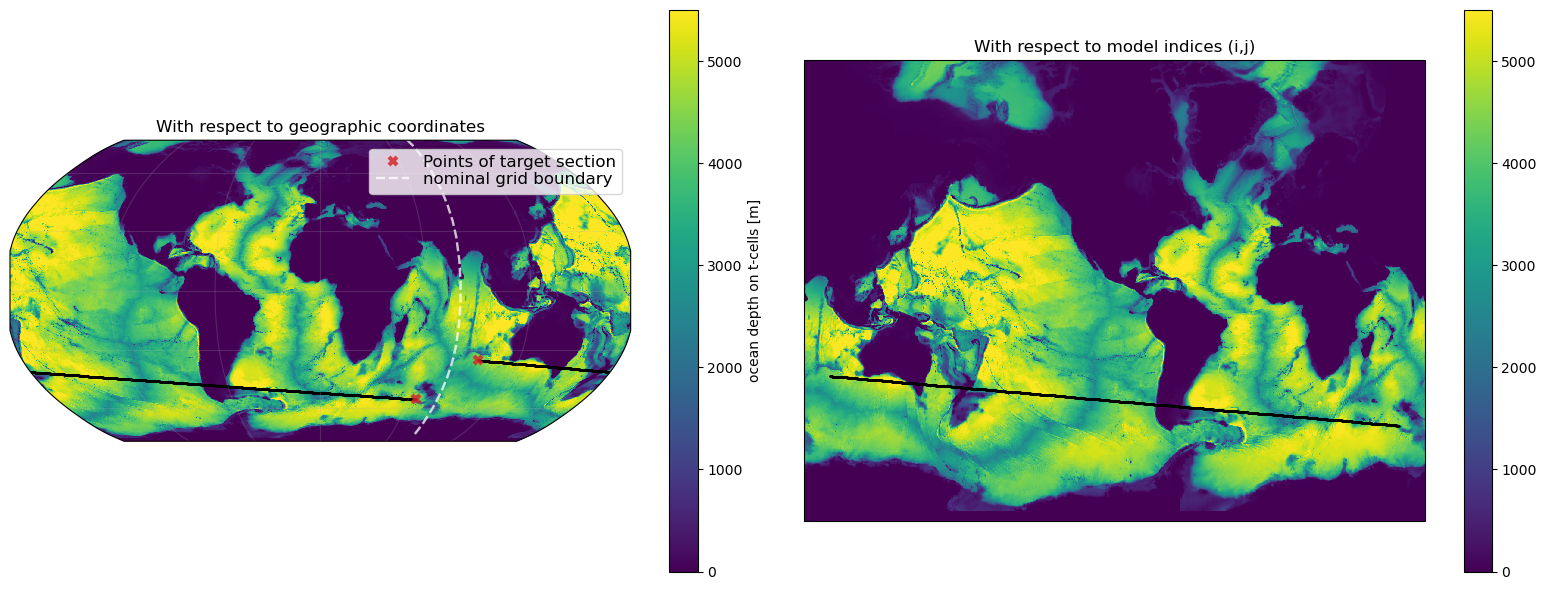

In [9]:
plot_sections(i, j, x, y, section_lons, section_lats, grid);

### Correct behavior with `periodic=True` (new default)

In [10]:
i, j, x, y = sectionate.create_section_composite(
    grid['geolon_c'],
    grid['geolat_c'],
    section_lons,
    section_lats
)

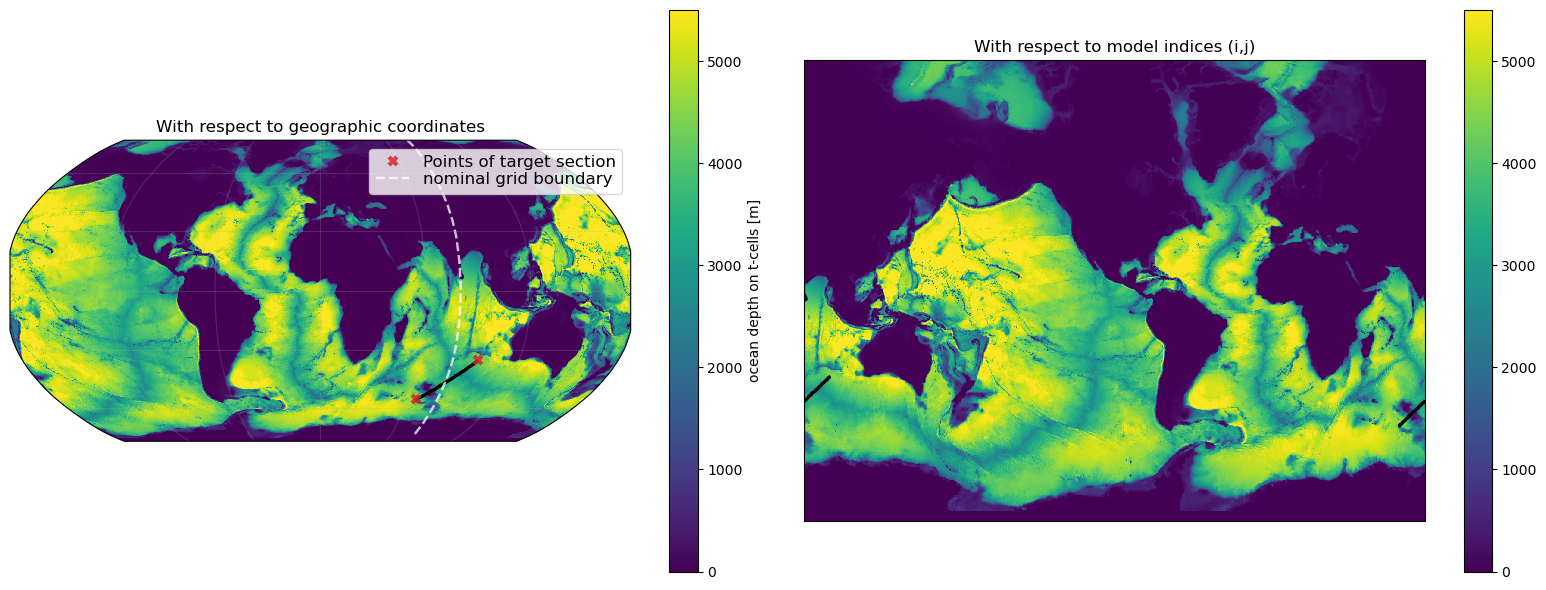

In [11]:
plot_sections(i, j, x, y, section_lons, section_lats, grid);

## 2.  Zonally-periodic sections

### Sectionate requires intermediate points to disambiguate zonal sections longer than 180º

Consider the case below where we aim to make a zonally-circumpolar section that passes through Drake Passage at 60ºS.

In [24]:
lat = -57.5

##### Incorrect behavior: no intermediate points $\rightarrow$ no section required to connect consecutive points

In [25]:
section_lons=[0, 360]
section_lats=[lat]*len(section_lons)

In [26]:
i, j, x, y = sectionate.create_section_composite(
    grid['geolon_c'],
    grid['geolat_c'],
    section_lons,
    section_lats
)

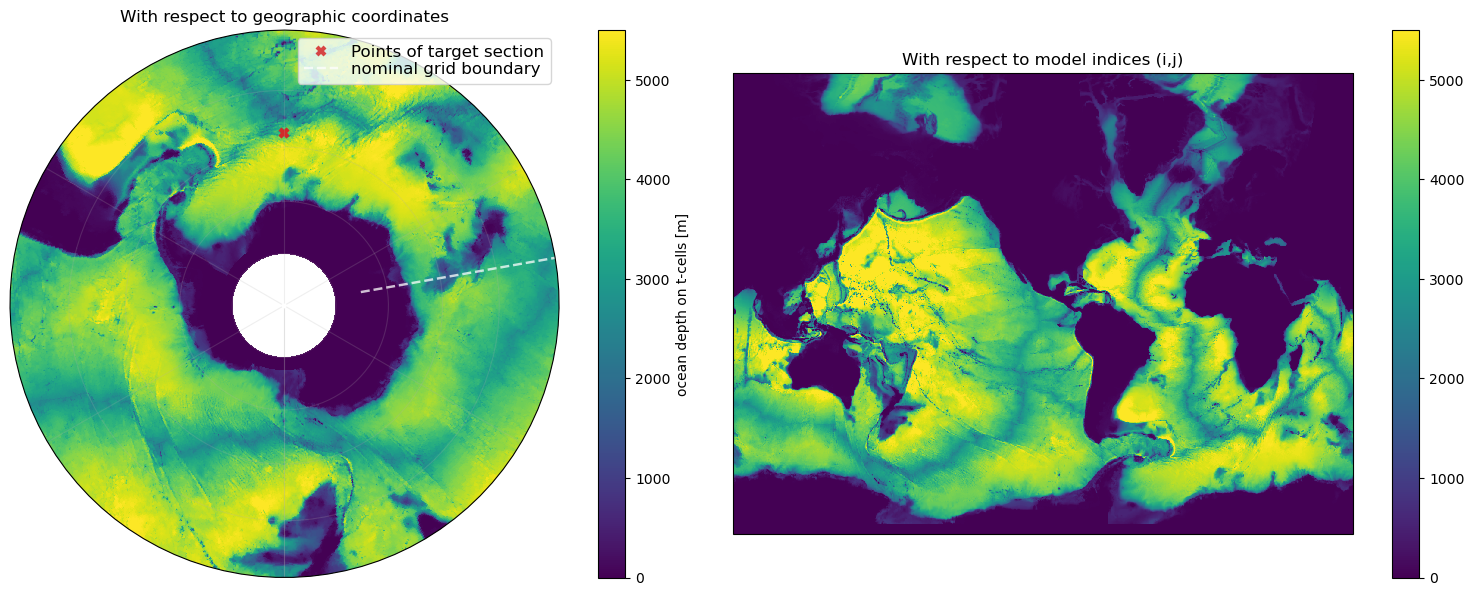

In [27]:
plot_sections(i, j, x, y, section_lons, section_lats, grid, projection=ccrs.SouthPolarStereo());

##### Incorrect behavior: intermediate points more than 180º apart $\rightarrow$ shortest subsections do not cirumnavigate (and just go out and back)

In [28]:
section_lons=[0, 240, 360]
section_lats=[lat]*len(section_lons)

In [29]:
i, j, x, y = sectionate.create_section_composite(
    grid['geolon_c'],
    grid['geolat_c'],
    section_lons,
    section_lats
)

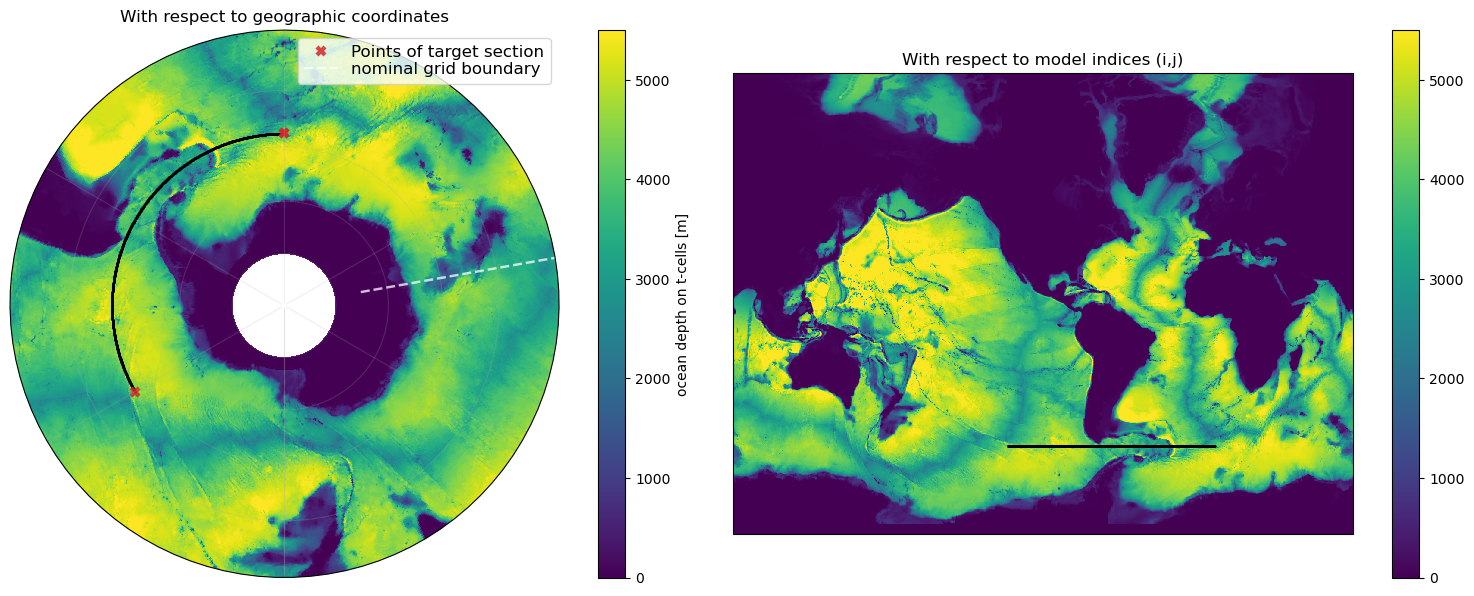

In [30]:
plot_sections(i, j, x, y, section_lons, section_lats, grid, projection=ccrs.SouthPolarStereo());

##### Correct behavior: series of intermediate points less than 180º apart 

In [31]:
section_lons=[0, 120, 240, 360]
section_lats=[lat]*len(section_lons)

In [32]:
i, j, x, y = sectionate.create_section_composite(
    grid['geolon_c'],
    grid['geolat_c'],
    section_lons,
    section_lats
)

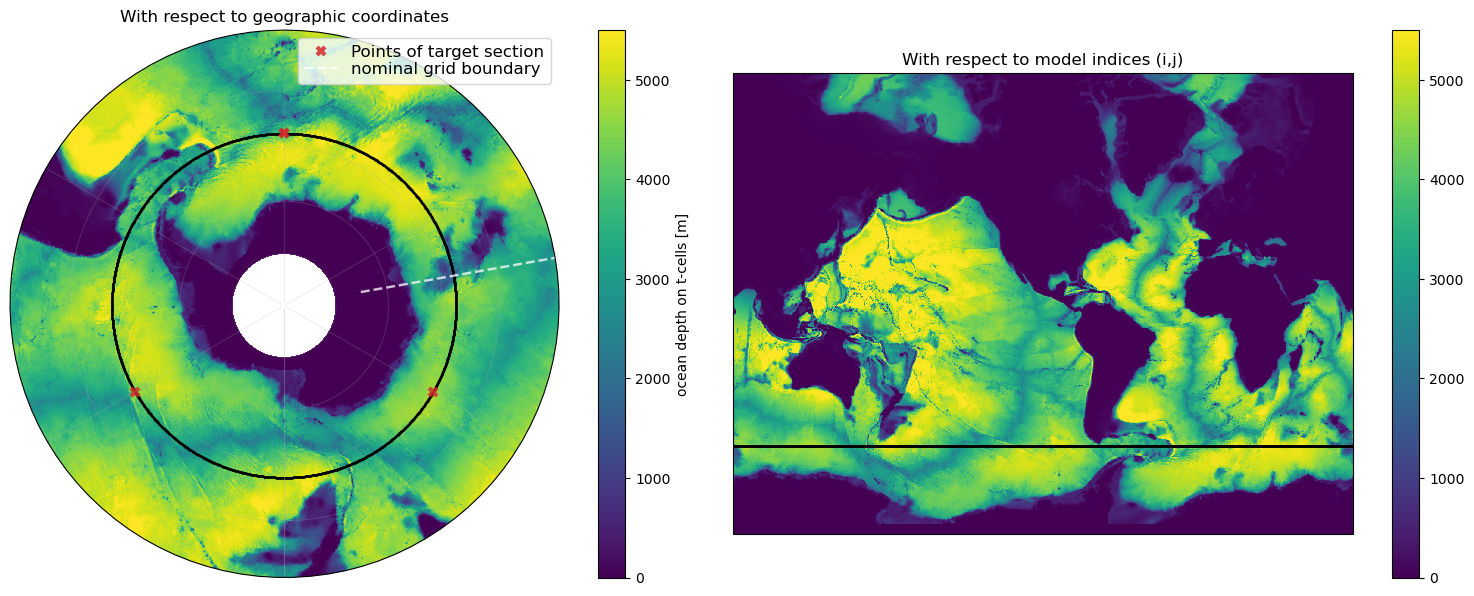

In [33]:
plot_sections(i, j, x, y, section_lons, section_lats, grid, projection=ccrs.SouthPolarStereo());

## 3. Example of a complex section that crosses the boundary multiple times

In [37]:
section_lons=np.arange(0, 360*3, 10.)
section_lats= lat + section_lons*(10/3.)/360. + 5*np.sin(5* (2*np.pi*section_lons/360.))
section_lons = np.append(section_lons, section_lons[0])
section_lats = np.append(section_lats, section_lats[0])

In [38]:
i, j, x, y = sectionate.create_section_composite(
    grid['geolon_c'],
    grid['geolat_c'],
    section_lons,
    section_lats
)

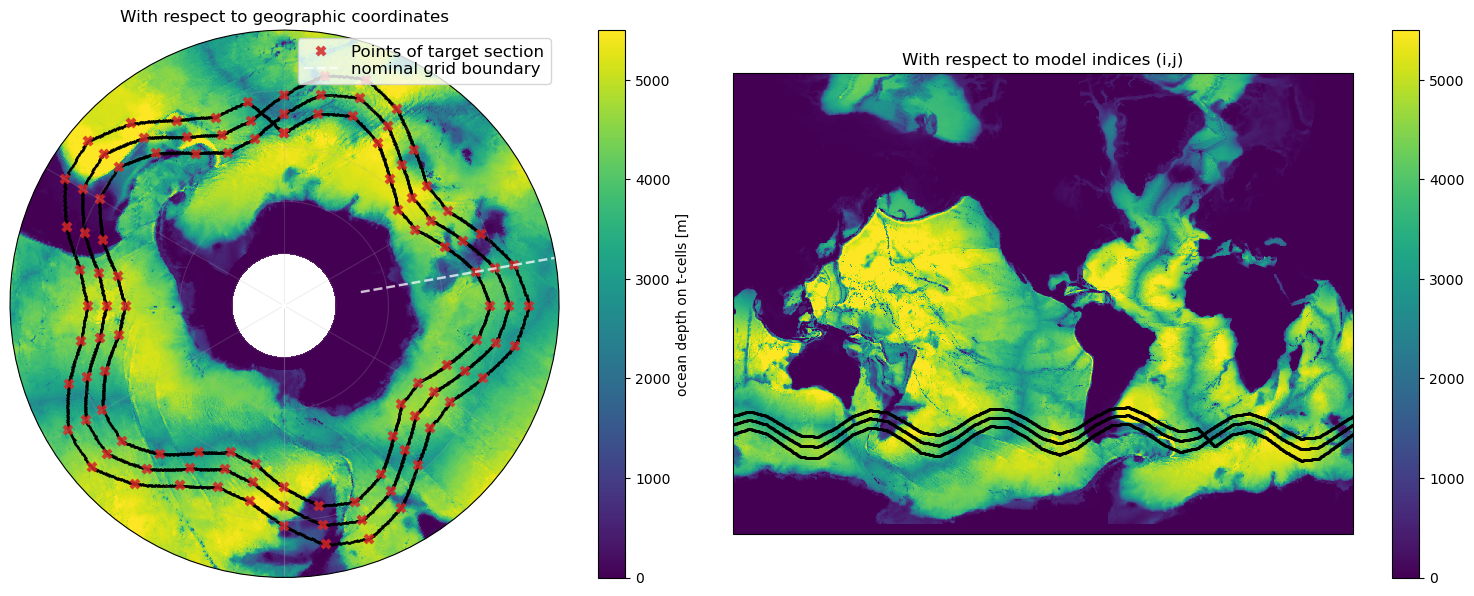

In [39]:
plot_sections(i, j, x, y, section_lons, section_lats, grid, projection=ccrs.SouthPolarStereo());